In [1]:
import torch
from torchvision import datasets, transforms
from PIL import Image

from dino import MultiCropAugmentation
from main_dino import DataAugmentationDINO
import my_utils as U


/home/felix/miniconda3/envs/dino/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# original dino transform
global_crops_scale = (0.4, 1.)
local_crops_scale = (0.05, 0.4)
local_crops_number = 8
 
convert_to_RGB = transforms.Lambda(lambda img: img.convert('RGB'))
dino_trfm = DataAugmentationDINO(
        global_crops_scale,
        local_crops_scale,
        local_crops_number,
    )

dino_trfm = transforms.Compose([convert_to_RGB, dino_trfm])

In [3]:
# new multicrop augmentation transform
MC_SPEC = [
        {'name':'global1', 'out_size':128, 'min_scale':0.6, 'max_scale':1.0, 'teacher':True, 'student':True},
        {'name':'global2', 'out_size':128, 'min_scale':0.6, 'max_scale':1.0, 'teacher':True, 'student':True},
        {'name':'local1', 'out_size':96, 'min_scale':0.2, 'max_scale':0.4, 'teacher':False, 'student':True},
        {'name':'local2', 'out_size':96, 'min_scale':0.2, 'max_scale':0.4, 'teacher':False, 'student':True},
        {'name':'local3', 'out_size':96, 'min_scale':0.2, 'max_scale':0.4, 'teacher':False, 'student':True},
        {'name':'local4', 'out_size':96, 'min_scale':0.2, 'max_scale':0.4, 'teacher':False, 'student':True},
    ]

self_trfm = transforms.Compose([ # self-training
                transforms.Lambda(lambda img: img.convert('RGB')),
                transforms.ToTensor()
            ])

mc = MultiCropAugmentation(MC_SPEC, per_crop_transform=self_trfm)

### Progressively show dataset creation

In [4]:
data_path = "datasets/"
dataset = datasets.MNIST(data_path, train=True)

In [5]:
## Inspect dataset
print(len(dataset))
img, lbl = dataset[0]
img.show()

# inspect convert_to_RGB
img = convert_to_RGB(img)
img.show()


60000


In [6]:
# apply transform
torch.manual_seed(1)

print(U.recshape(dino_trfm(img)))
print(U.recshape(mc(img)))



list of length 10
  1. Tensor of shape torch.Size([3, 224, 224])
  2. Tensor of shape torch.Size([3, 224, 224])
  3. Tensor of shape torch.Size([3, 96, 96])
  4. Tensor of shape torch.Size([3, 96, 96])
  5. Tensor of shape torch.Size([3, 96, 96])
  6. Tensor of shape torch.Size([3, 96, 96])
  7. Tensor of shape torch.Size([3, 96, 96])
  8. Tensor of shape torch.Size([3, 96, 96])
  9. Tensor of shape torch.Size([3, 96, 96])
  10. Tensor of shape torch.Size([3, 96, 96])

list of length 6
  1. Tensor of shape torch.Size([3, 128, 128])
  2. Tensor of shape torch.Size([3, 128, 128])
  3. Tensor of shape torch.Size([3, 96, 96])
  4. Tensor of shape torch.Size([3, 96, 96])
  5. Tensor of shape torch.Size([3, 96, 96])
  6. Tensor of shape torch.Size([3, 96, 96])


label: 5
type(sample): <class 'list'>


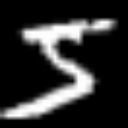

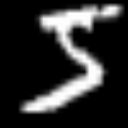

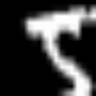

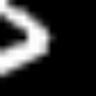

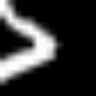

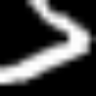

In [8]:
dataset = datasets.MNIST(data_path, train=True, transform=mc)

for sample, lbl in dataset:
    print(f'label: {lbl}')
    print(f'type(sample): {type(sample)}')

    for x in sample:
        transforms.functional.to_pil_image(x).show()
        
    break

In [9]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2)

for batch, lbls in data_loader:
    
    U.recshape(batch, prefix='batch: ')
    U.recshape(lbls, prefix='lbls: ')
    break